# Kramers Kronig Analysis of Hemoglobin

## Description

This note was developed as I wanted to find a method for calculating the refractive index of biological materials, in particular for simulations of the hyperspectral optical-field-resolved microscope.  Then focus of this note is particularly on calculating the refractive index of hemoglobin/red blood cells, however it can be applied in general to a host of materials where extinction spectra are known. 

## Introduction

In {cite:p}`biModelingLightScattering2013` a full model including the shape and refractive index of red blood cells is described.  There, they address the modeling of complex refractive index of hemoglobin for this purpose.  They suggest using the method as described in {cite:p}`faberOxygenSaturationDependentAbsorption2004`.  

In {cite:p}`faberOxygenSaturationDependentAbsorption2004`, they describe how Kramers Kronig relations can be used to determine the complete refractive index of hemoglobin from extinction measurements of Hemoglobin in the form of red blood cells (both oxygenated and unoxygenated).  Their analysis was based on the dataset provided by Scott Prahl (this data can be found through [this website](https://omlc.org/spectra/hemoglobin/)).  Note that extinction spectra from performed as follows:

 1. Take experimentally measured values for absorption -- related directly to $\mu_{a}$ (this is derived from [here](https://omlc.org/spectra/hemoglobin/)).
 2. Use this to determine $\kappa(\omega)$ (eq. (1) in {cite:p}`faberOxygenSaturationDependentAbsorption2004`
 3. Use $\kappa(\omega)$ to then determine $n(\omega)$ (eq. (2) in {cite:p}`faberOxygenSaturationDependentAbsorption2004`).  This is the real part of the refractive index.

In the following, we perform these three steps to compute the full complex refractive index of both oxygenated and deoxygenated red blood cells.  So that this information can be incorporated into FDTD electromagnetic models, we also fit this dispersion data using Drude-Lorentz oscillators.

## Headers and Functions for the Analysis

In the following block we load any needed packages for analysis.  We also define three core functions that will be used in the remainder of this note:

 1. `n_kk(y, k, y_0, n_0, dw_prime)` This function takes in wavelength and absorption data along with a single refractive index at a fixed wavelength to then determine the full real part of the refractive index of a medium through Kramers-Kronig analysis.  The approach used is the same as described in {cite:p}`faberOxygenSaturationDependentAbsorption2004`
 2. `eps_drude_lorentz(p, y)` Takes coefficients defined as a vector in =p= and uses those to calculate the complex epsilon of a material as a function of wavelength `y`.
 3. `residuals(p, y, eps_meas)` Convenience function for calculating a vector of residuals that are used by `scipy.optimize.least_squares` to then fit the measured permittivity `eps_meas` using oscillators defined by `p`.  This can then be used to define materials for FDTD analysis (for e.g. using tools like [MEEP](https://meep.readthedocs.io/en/latest/)).

In [3]:
#Setup the workspace
%reset
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.interpolate as interpolate
import scipy.optimize as sco

import sys
sys.path.append('../includes')
import physical_constants_SI as pcSI


def n_kk(y, k, y_0, n_0, dw_prime):
    """
    Evaluates the refractive index from the absorption values k as a function of 
    frequency, w.  The index is evaluated over all values w thus providing full
    complex index information (n + ik) for the material.  Only one real index of
    refraction value, n_0 evaluated at frequency w_0, is needed for the offset. 

    The absorption terms k can be derived from extinction data.  This is very 
    useful as often times the extinction is measured from many specimens in the
    laboratory, meaning that this offers a way to evaluate refractive index from
    a variety of complex substances.  

    Inputs     Units     Description
    ------     -----     -----------
     y         nm        Wavelength vector associated with vector of k values.  
                         Must be monotonic increasing.
     k                   Vector of k-values.  Can be derived from extinction data.
     y_0       nm        The central wavelength where a known index n_0 is provided. 
     n_0                 The known index at y_0.
     dw_prime  1/nm      The spacing for the numerical integral over w_prime in the 
                         Kramers-Kronig calculation.  This should be small-enough 
                         to provide convergence of the refractive index calculation.
                         It is with respect to normalized frequency (simply 1/y)


    Outputs
    -----------
     n         Vector containing the real part of the refractive index
    """

    #Normalized frequency (simply 1/wavelength)
    w_norm = 1/y
    w_norm_0 = 1/y_0

    #Interpolation function:
    f_k = interpolate.interp1d(np.flip(w_norm),
                            np.flip(k), 
                            kind='cubic')

    n_prime = np.zeros(w_norm.shape)
    
    cc = 0
    for w_norm_eval in w_norm:

        #You are going to have 3 ranges:
        w_norm_p1 = np.min([w_norm_0, w_norm_eval])
        w_norm_p2 = np.max([w_norm_0, w_norm_eval])

        sum1 = 0
        sum2 = 0
        sum3 = 0

        #This will be the first range:
        N_1 = int(np.ceil((w_norm_p1 - dw_prime - w_norm[-1])/dw_prime))
        if (N_1 >= 0):
            w_norm_prime_1 = np.linspace(w_norm[-1], w_norm_p1 - dw_prime, N_1)
            k_Hb_prime_1 = f_k(w_norm_prime_1)
            integrand_1 = w_norm_prime_1*k_Hb_prime_1*(w_norm_0**2 - w_norm_eval**2)/\
                (w_norm_eval**2 - w_norm_prime_1**2)/(w_norm_0**2 - w_norm_prime_1**2)

            sum1 = np.trapz(integrand_1, x=w_norm_prime_1)
        

        #This will be the second range:
        N_2 = int(np.ceil((w_norm_p2 - dw_prime - (w_norm_p1 + dw_prime))/dw_prime))
        if (N_2 >= 0):
            w_norm_prime_2 = np.linspace(w_norm_p1 + dw_prime, w_norm_p2 - dw_prime, N_2)
            k_Hb_prime_2 = f_k(w_norm_prime_2)
            integrand_2 = w_norm_prime_2*k_Hb_prime_2*(w_norm_0**2 - w_norm_eval**2)/\
                (w_norm_eval**2 - w_norm_prime_2**2)/(w_norm_0**2 - w_norm_prime_2**2)
                
            sum2 = np.trapz(integrand_2, x=w_norm_prime_2)

            #This will be the third range:
            N_3 = int(np.ceil((w_norm[0] - (w_norm_p2 + dw_prime))/dw_prime))
        if (N_3 >= 0):
            w_norm_prime_3 = np.linspace(w_norm_p2 + dw_prime, w_norm[0], N_3)
            k_Hb_prime_3 = f_k(w_norm_prime_3)
            integrand_3 = w_norm_prime_3*k_Hb_prime_3*(w_norm_0**2 - w_norm_eval**2)/\
                (w_norm_eval**2 - w_norm_prime_3**2)/(w_norm_0**2 - w_norm_prime_3**2)
            
            sum3 = np.trapz(integrand_3, w_norm_prime_3)
            
        n_prime[cc] = (-2/np.pi)*(sum1 + sum2 + sum3)
        cc = cc + 1

    n = n_0 + n_prime

    return n

def eps_drude_lorentz(p, y):

    eps = p[0]

    p_sets = int((p.size - 1)/3)

    for cc in range(0, p_sets):

        alpha = p[3*cc + 1]
        beta = p[3*cc + 2]
        sigma = p[3*cc + 3]
        
        eps = eps + sigma*alpha**2*y**2/(alpha**2*y**2 - 1 - 1j*y*beta)

    return eps

def residuals(p, y, eps_meas):

    eps_calc = eps_drude_lorentz(p, y)

    M = np.abs(eps_calc - eps_meas)

    return M

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Calculate k-Values from Extinction Data

In the following code block, we evaluate the k-values using the extinction data.  This follows directly from the method described by Prahl [here](https://omlc.org/spectra/hemoglobin/summary.html).

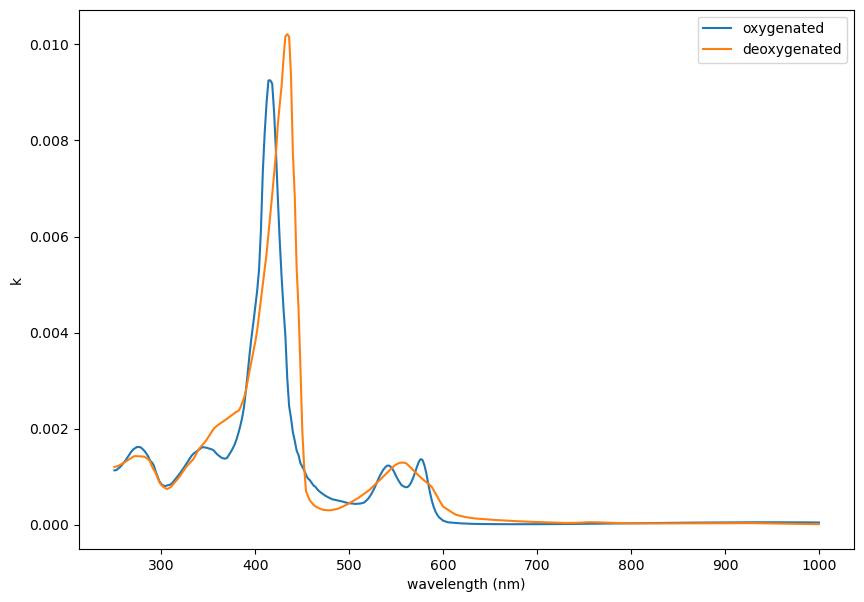

In [4]:
data = sio.loadmat('../data/Hb_extinction_data.mat')
        
wavelength = np.squeeze(data['wavelength'])
w_norm = 1/wavelength
HbO2 = np.squeeze(data['HbO2'])
Hb = np.squeeze(data['Hb'])

x = 150 #g/liter of solution
alpha = 2.303*x/64500

k_Hb = alpha*wavelength*1e-7*Hb/(4*np.pi)
k_HbO2 = alpha*wavelength*1e-7*HbO2/(4*np.pi)

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(wavelength, k_HbO2, label = 'oxygenated')
plt.plot(wavelength, k_Hb, label = 'deoxygenated')
plt.xlabel('wavelength (nm)')
plt.ylabel('k')
plt.legend()
plt.show()

## Calculate Refractive Index from k-Values Using Kramers-Kronig Relation

Now we use the method discussed in {cite:p}`faberOxygenSaturationDependentAbsorption2004` to calculate the refractive index using Kramers-Kronig analysis.

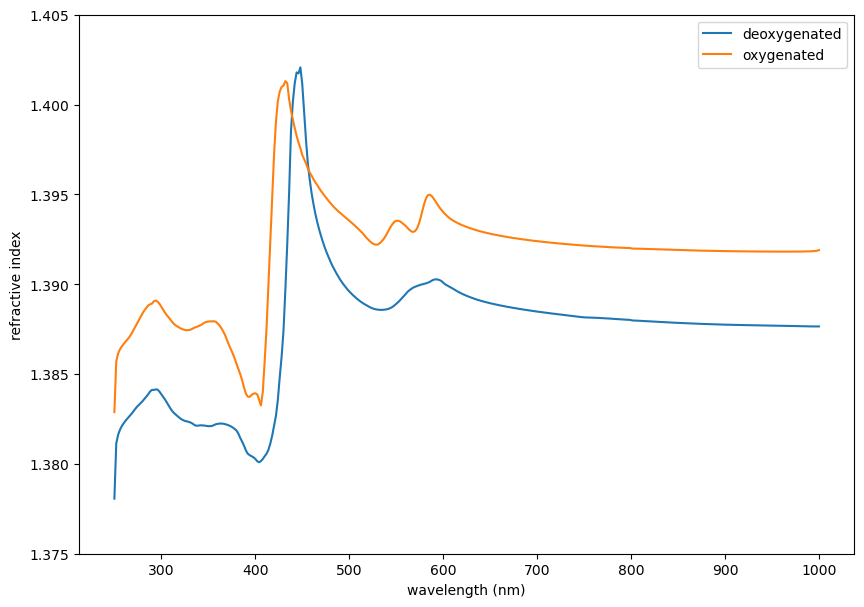

In [5]:
#Central frequency
w_norm_0 = 1/800

x = 300 #g/liter of solutiond...
        #currently using as a scaling factor for data fitting
alpha = 2.303*x/64500

k_Hb = alpha*wavelength*1e-7*Hb/(4*np.pi)
k_HbO2 = alpha*wavelength*1e-7*HbO2/(4*np.pi)

#Set number of desired points over whole range and find
#resolution for integral: dw_int
N = 5000
dw_int = (w_norm[0] - w_norm[-1])/N
n_prime = np.zeros(w_norm.shape)

n_prime = n_kk(wavelength, k_Hb, 800, 1.388, dw_int)
n_prime_O2 = n_kk(wavelength, k_HbO2, 800, 1.392, dw_int)

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(wavelength, n_prime, label='deoxygenated')
plt.plot(wavelength, n_prime_O2, label='oxygenated')
plt.ylim(1.375, 1.405)
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('refractive index')

plt.show()

## Drude-Lorentz Oscillator Fit to Data

Finally, we take the permittivity of this analysis and use it to determine a series of oscillators that will fit the data using a Drude-Lorentz model.  We use the model as discussed in the [MEEP documentation](https://meep.readthedocs.io/en/latest/Materials/), and the appendix of {cite:p}`buckleyNanoantennaDesignEnhanced2021`, for convenience as we aim to use this information inside of MEEP for other purposes.

Note that the terms `alpha`, `beta` and `sigma` below and in [cite:@buckleyNanoantennaDesignEnhanced2021] are equivalent to `frq`, `gam`, and `sig` in the MEEP code.  

Note that for convenience, we only perform these fits over a fixed wavelength range greater than 450 nm (not the entire range).  It could easily be extended if desired.

### Deoxygenated Case

First, we perform the fit for the deoxygenated case.

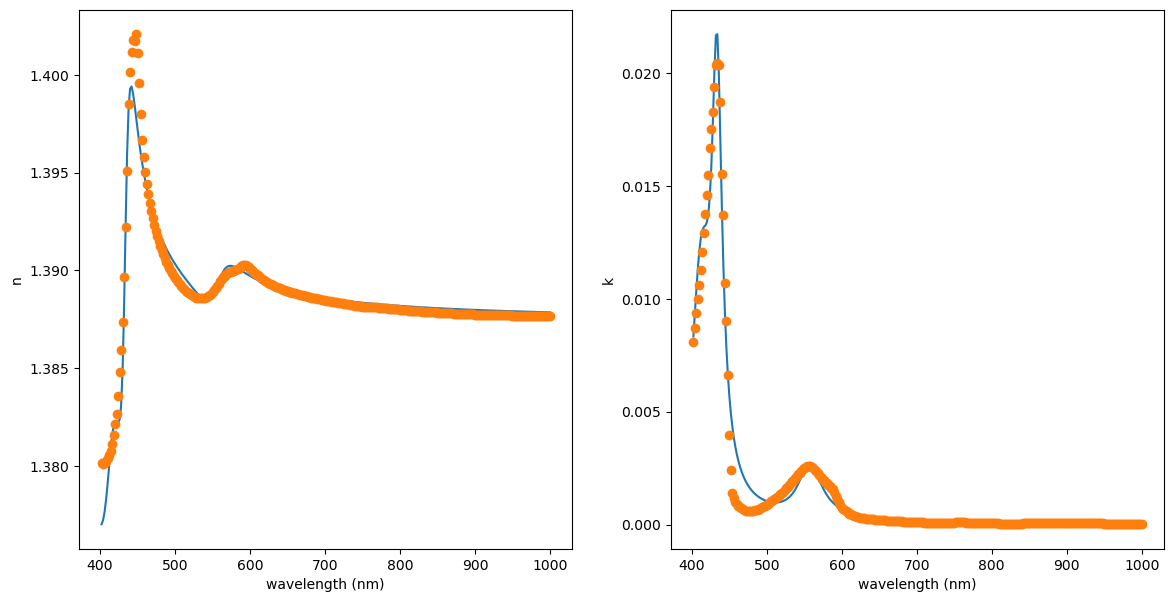

In [6]:
eps_meas = (n_prime + 1j*k_Hb)**2

y_min = 400
y_range = np.where(wavelength > y_min)
y_high = wavelength[y_range[0]]
eps_meas = eps_meas[y_range[0]]


p0 = np.array([1.92,
               2.4, 0.1, 0.003,
               2.3, 0.08, 0.003,
               1.8, 0.05, 0.005])

res = sco.least_squares(residuals, p0, args=(1e-3*y_high, eps_meas), max_nfev = 50000, xtol=1e-8)

eps_opt = eps_drude_lorentz(res.x, y_high*1e-3)

fig = plt.figure()
fig.set_size_inches(14, 7)

ax1 = fig.add_subplot(1, 2, 1)

ax1.plot(y_high, np.real(np.sqrt(eps_opt)), label='fit')
ax1.plot(y_high, np.real(np.sqrt(eps_meas)), 'o', label='data')
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('n')


ax2 = fig.add_subplot(1, 2, 2)


ax2.plot(y_high, np.imag(np.sqrt(eps_opt)), label='fit')
ax2.plot(y_high, np.imag(np.sqrt(eps_meas)), 'o', label='data')
ax2.set_xlabel('wavelength (nm)')
ax2.set_ylabel('k')

plt.show()

#### MEEP Material Definition

The output of the following code block defines the de-oxygenated hemoglobin material definition as a MEEP material for convenience.  This can then be added to any MEEP simulation to simulate the optical properties of a red blood cell for instance.  See [here](https://meep.readthedocs.io/en/latest/Materials/) for a description of MEEP materials.

In [7]:
mat_name = 'Hb'
x = res.x

#Define all of the parameters here:
print(mat_name + '_range = mp.FreqRange(min=um_scale, max=um_scale/' + str(y_min*1e-3) + ')')

print(mat_name + '_eps_inf = ' + str(x[0]) + '\n')

num = 1
for cc in range(0, int((x.size - 1)/3)):
    print(mat_name + '_frq' + str(num) + ' = ' + str(x[3*cc + 1]) + '/um_scale')
    print(mat_name + '_gam' + str(num) + ' = ' + str(x[3*cc + 2]) + '/um_scale')
    print(mat_name + '_sig' + str(num) + ' = ' + str(x[3*cc + 3]) + '\n')
    num = num + 1

#Now the output for defining the susceptibilities:
print(mat_name + '_susc = [mp.LorentzianSusceptibility(frequency=' + mat_name + '_frq1,' + \
    'gamma=' + mat_name + '_gam1, sigma=' + mat_name + '_sig1)]')

num = 2
for cc in range(1, int((x.size - 1)/3)):

    print(mat_name + '_susc.append(mp.LorentzianSusceptibility(frequency=' + mat_name + '_frq' + str(num) +',' + \
          'gamma=' + mat_name + '_gam' + str(num) + ', sigma=' + mat_name + '_sig' + str(num) + '))')
    num = num + 1

#Finally, define the material: 
print('')
print(mat_name + ' = mp.Medium(epsilon=' + mat_name + '_eps_inf, E_susceptibilities=' + mat_name + '_susc, ' + \
      'valid_freq_range=' + mat_name + '_range)')

Hb_range = mp.FreqRange(min=um_scale, max=um_scale/0.4)
Hb_eps_inf = 1.9204613356930944

Hb_frq1 = 2.425739251299398/um_scale
Hb_gam1 = 0.18899320982566495/um_scale
Hb_sig1 = 0.0022859170192929194

Hb_frq2 = 2.3068451311889477/um_scale
Hb_gam2 = 0.08748741374271483/um_scale
Hb_sig2 = 0.001867059599216536

Hb_frq3 = 1.7948478593572692/um_scale
Hb_gam3 = 0.12395529040291549/um_scale
Hb_sig3 = 0.0004489168927026274

Hb_susc = [mp.LorentzianSusceptibility(frequency=Hb_frq1,gamma=Hb_gam1, sigma=Hb_sig1)]
Hb_susc.append(mp.LorentzianSusceptibility(frequency=Hb_frq2,gamma=Hb_gam2, sigma=Hb_sig2))
Hb_susc.append(mp.LorentzianSusceptibility(frequency=Hb_frq3,gamma=Hb_gam3, sigma=Hb_sig3))

Hb = mp.Medium(epsilon=Hb_eps_inf, E_susceptibilities=Hb_susc, valid_freq_range=Hb_range)


### Oxygenated Case

This is the same procedure for the deoxygenated case above.

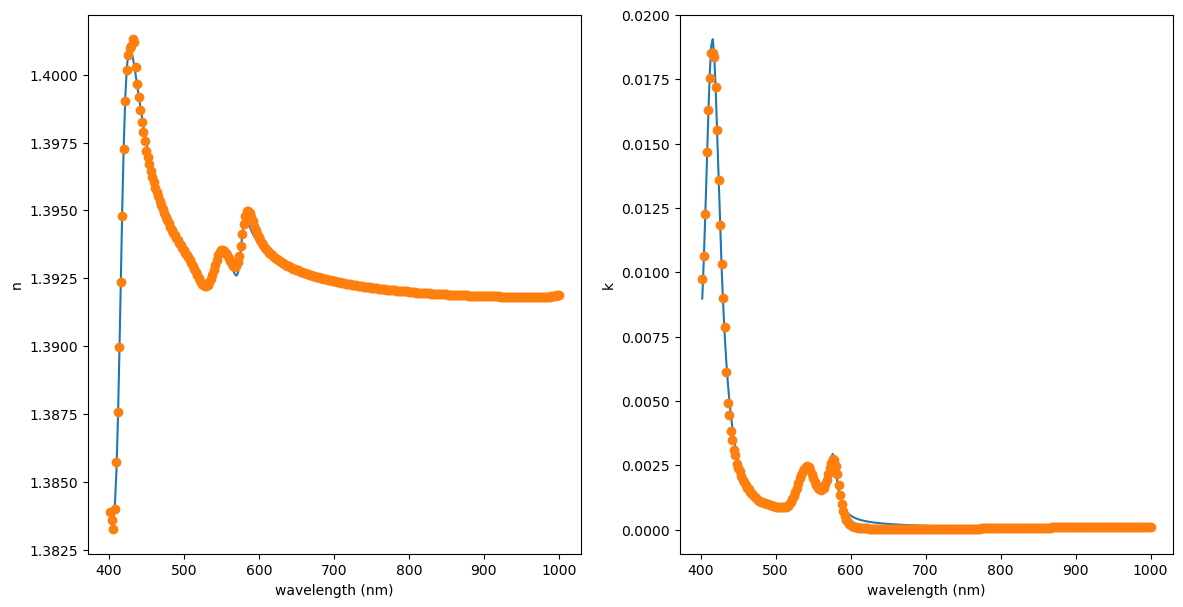

In [8]:
eps_meas_O2 = (n_prime_O2 + 1j*k_HbO2)**2

y_min = 400
y_range = np.where(wavelength > y_min)
y_high = wavelength[y_range[0]]
eps_meas_O2 = eps_meas_O2[y_range[0]]

p0 = np.array([1.9,
               2.5, 0.1, 0.003,
               2.3, 0.08, 0.003,
               1.8, 0.05, 0.0005,
               1.7, 0.05, 0.0005])


res_O2 = sco.least_squares(residuals, p0, args=(1e-3*y_high, eps_meas_O2), max_nfev = 50000, xtol=1e-8)

eps_opt_O2 = eps_drude_lorentz(res_O2.x, y_high*1e-3)

#squared_error(res.x, 1e-3*wavelength, eps_meas)

fig = plt.figure()
fig.set_size_inches(14, 7)

ax1 = fig.add_subplot(1, 2, 1)

ax1.plot(y_high, np.real(np.sqrt(eps_opt_O2)), label='fit')
ax1.plot(y_high, np.real(np.sqrt(eps_meas_O2)), 'o', label='data')
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('n')

ax2 = fig.add_subplot(1, 2, 2)

ax2.plot(y_high, np.imag(np.sqrt(eps_opt_O2)), label='fit')
ax2.plot(y_high, np.imag(np.sqrt(eps_meas_O2)), 'o', label='data')
ax2.set_xlabel('wavelength (nm)')
ax2.set_ylabel('k')

plt.show()

#### MEEP Material Definition

The output of the following code block defines the oxygenated hemoglobin material definition as a MEEP material for convenience.  This can then be added to any MEEP simulation to simulate the optical properties of a red blood cell for instance.  See [here](https://meep.readthedocs.io/en/latest/Materials/) for a description of MEEP materials.

In [9]:
mat_name = 'HbO2'
x = res_O2.x

#Define all of the parameters here:
print(mat_name + '_range = mp.FreqRange(min=um_scale, max=um_scale/' + str(y_min*1e-3) + ')')

print(mat_name + '_eps_inf = ' + str(x[0]) + '\n')

num = 1
for cc in range(0, int((x.size - 1)/3)):
    print(mat_name + '_frq' + str(num) + ' = ' + str(x[3*cc + 1]) + '/um_scale')
    print(mat_name + '_gam' + str(num) + ' = ' + str(x[3*cc + 2]) + '/um_scale')
    print(mat_name + '_sig' + str(num) + ' = ' + str(x[3*cc + 3]) + '\n')
    num = num + 1

#Now the output for defining the susceptibilities:
print(mat_name + '_susc = [mp.LorentzianSusceptibility(frequency=' + mat_name + '_frq1,' + \
    'gamma=' + mat_name + '_gam1, sigma=' + mat_name + '_sig1)]')

num = 2
for cc in range(1, int((x.size - 1)/3)):

    print(mat_name + '_susc.append(mp.LorentzianSusceptibility(frequency=' + mat_name + '_frq' + str(num) +',' + \
          'gamma=' + mat_name + '_gam' + str(num) + ', sigma=' + mat_name + '_sig' + str(num) + '))')
    num = num + 1

#Finally, define the material: 
print('')
print(mat_name + ' = mp.Medium(epsilon=' + mat_name + '_eps_inf, E_susceptibilities=' + mat_name + '_susc, ' + \
      'valid_freq_range=' + mat_name + '_range)')

HbO2_range = mp.FreqRange(min=um_scale, max=um_scale/0.4)
HbO2_eps_inf = 1.9309747551301373

HbO2_frq1 = 2.665440135712604/um_scale
HbO2_gam1 = 0.05531174295631055/um_scale
HbO2_sig1 = 0.0012472226347621234

HbO2_frq2 = 2.406957892056221/um_scale
HbO2_gam2 = 0.1467597503016222/um_scale
HbO2_sig2 = 0.003194232393855132

HbO2_frq3 = 1.8486889261138144/um_scale
HbO2_gam3 = 0.10013538512305616/um_scale
HbO2_sig3 = 0.00032574995735006306

HbO2_frq4 = 1.7361480652434025/um_scale
HbO2_gam4 = 0.04233333456840626/um_scale
HbO2_sig4 = 0.00015979022951372748

HbO2_susc = [mp.LorentzianSusceptibility(frequency=HbO2_frq1,gamma=HbO2_gam1, sigma=HbO2_sig1)]
HbO2_susc.append(mp.LorentzianSusceptibility(frequency=HbO2_frq2,gamma=HbO2_gam2, sigma=HbO2_sig2))
HbO2_susc.append(mp.LorentzianSusceptibility(frequency=HbO2_frq3,gamma=HbO2_gam3, sigma=HbO2_sig3))
HbO2_susc.append(mp.LorentzianSusceptibility(frequency=HbO2_frq4,gamma=HbO2_gam4, sigma=HbO2_sig4))

HbO2 = mp.Medium(epsilon=HbO2_eps_inf, E_suscept

## Hemoglobin Extinction Data

The following files contain the hemoglobin extinction data used for this code.  They are the same, just two different formats (.mat and .csv).  

{download}`Hb Extinction Data -- MAT <../data/Hb_extinction_data.mat>`

{download}`Hb Extinction Data -- CSV <../data/Hb_extinction_data.csv>`



## References

```{bibliography}
:filter: docname in docnames
:style: unsrt
```